In [235]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import random
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 결측치가 있는지 확인하기(우선은 제거하는 방식)
if pd.isnull(train['x']).sum() > 0 or pd.isnull(train['y']).sum() > 0:
    train = train.dropna()
if pd.isnull(test['x']).sum() > 0 or pd.isnull(test['y']).sum() > 0:
    test = test.dropna()

train_dataset = train.sample(frac=1).reset_index(drop=True)
test_dataset = test.sample(frac=1).reset_index(drop=True)

In [236]:
train_corpus = []
for words in train['x']:
    sentence = ""
    for word in words.split(","):
        sentence += word + " "
    sentence = sentence[:len(sentence)-1]

    train_corpus.append(sentence)
    
test_corpus = []
for words in test['x']:
    sentence = ""
    for word in words.split(","):
        sentence += word + " "
    sentence = sentence[:len(sentence)-1]

    test_corpus.append(sentence)

In [237]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)


train_vectors = vectorizer.fit_transform(train_corpus)
# 테스트 데이터는 훈련 데이터로 맞춰놓은 벡터 변환기를 사용해야 함
test_vectors = vectorizer.transform(test_corpus)


X_train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer.get_feature_names())
y_train_df = pd.DataFrame(train['y'].values, columns=['target'])
y_test_df = pd.DataFrame(test['y'].values, columns=['target'])


target_names = list(set(train['y']))
target_mapping_table = {}
for idx, names in enumerate(target_names):
    target_mapping_table[names] = idx

    
y_train_df['target'] = y_train_df['target'].map(target_mapping_table)
y_test_df['target'] = y_test_df['target'].map(target_mapping_table)


train_df = pd.concat([X_train_df, y_train_df], axis=1)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

In [238]:
x_train = train_vectors.toarray()
x_test = test_vectors.toarray()
train_labels = y_train_df['target'].values
test_labels = y_test_df['target'].values

In [239]:
def to_one_hot(labels, dimension=6):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [240]:
print(x_train.shape)
print(one_hot_train_labels.shape)

print(x_test.shape)
print(one_hot_test_labels.shape)

(23384, 13229)
(23384, 6)
(5849, 13229)
(5849, 6)


In [241]:
len(x_train[0])

13229

In [242]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(13229, )))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [247]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [248]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [249]:
print(x_val.shape)
print(partial_x_train.shape)
print(y_val.shape)
print(partial_y_train.shape)

(1000, 13229)
(22384, 13229)
(1000, 6)
(22384, 6)


In [250]:
history = model.fit(x_train,
                    y_train, 
                    epochs=20)

Train on 23384 samples
Epoch 1/20
23384/23384 [==============================] - 4s 156us/sample - loss: 1.1930 - accuracy: 0.6058
Epoch 2/20
23384/23384 [==============================] - 3s 144us/sample - loss: 0.9356 - accuracy: 0.6768
Epoch 3/20
23384/23384 [==============================] - 3s 136us/sample - loss: 0.8773 - accuracy: 0.7007
Epoch 4/20
23384/23384 [==============================] - 3s 141us/sample - loss: 0.8328 - accuracy: 0.7164
Epoch 5/20
23384/23384 [==============================] - 3s 137us/sample - loss: 0.7950 - accuracy: 0.7300
Epoch 6/20
23384/23384 [==============================] - 3s 137us/sample - loss: 0.7646 - accuracy: 0.7425
Epoch 7/20
23384/23384 [==============================] - 3s 136us/sample - loss: 0.7371 - accuracy: 0.7522
Epoch 8/20
23384/23384 [==============================] - 3s 137us/sample - loss: 0.7135 - accuracy: 0.7600
Epoch 9/20
23384/23384 [==============================] - 3s 137us/sample - loss: 0.6899 - accuracy: 0.7675
Epoch

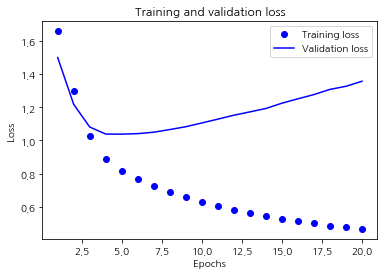

In [145]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

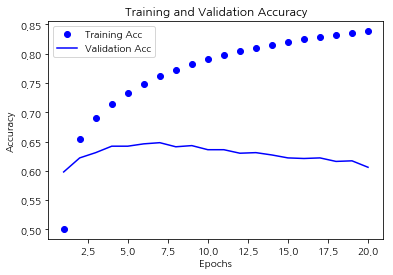

In [150]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [227]:
params = {
    'input_layer': [512],
    'hidden_layer': [512],
    'input_layer_activation': ['relu'],
    'hidden_layer_activation': ['relu'], 
    'output_layer_activation': ['softmax'],
    'optimizer': ['rmsprop'], 
    'epochs': [40], 
    'batch_size': [1000],
}

In [229]:
target_names = list(set(y_train))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_layer = int(params['input_layer'][0])
hidden_layer = int(params['hidden_layer'][0])
output_layer = len(target_names)

input_layer_activation = params['input_layer_activation'][0]
hidden_layer_activation = params['hidden_layer_activation'][0]
output_layer_activation = params['output_layer_activation'][0]

optimizer = params['optimizer'][0]
epochs = int(params['epochs'][0])
batch_size = int(params['batch_size'][0])

fnn_clf = Sequential()
fnn_clf.add(Dense(units=input_layer, activation=input_layer_activation, input_shape=(len(x_train[0]), )))
fnn_clf.add(Dense(units=hidden_layer, activation=hidden_layer_activation))
fnn_clf.add(Dense(units=output_layer, activation=output_layer_activation))

fnn_clf.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

fnn_clf.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

train_y_pred = fnn_clf.predict(x_train)
test_y_pred = fnn_clf.predict(x_test)

Train on 18707 samples, validate on 4677 samples
Epoch 1/40
18707/18707 [==============================] - 3s 138us/sample - loss: 1.3297 - accuracy: 0.5620 - val_loss: 1.0474 - val_accuracy: 0.6429
Epoch 2/40
18707/18707 [==============================] - 2s 97us/sample - loss: 0.8457 - accuracy: 0.7139 - val_loss: 0.9917 - val_accuracy: 0.6551
Epoch 3/40
18707/18707 [==============================] - 2s 94us/sample - loss: 0.6866 - accuracy: 0.7724 - val_loss: 1.0186 - val_accuracy: 0.6483
Epoch 4/40
18707/18707 [==============================] - 2s 97us/sample - loss: 0.5857 - accuracy: 0.8011 - val_loss: 1.0653 - val_accuracy: 0.6444
Epoch 5/40
18707/18707 [==============================] - 2s 108us/sample - loss: 0.5079 - accuracy: 0.8281 - val_loss: 1.1238 - val_accuracy: 0.6431
Epoch 6/40
18707/18707 [==============================] - 2s 108us/sample - loss: 0.4476 - accuracy: 0.8455 - val_loss: 1.1937 - val_accuracy: 0.6213
Epoch 7/40
18707/18707 [==============================

In [230]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(13229, )))
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', precision, recall, f1])

history2 = model.fit(x_train, 
                     y_train, 
                     epochs=40,
                     batch_size=1000,
                     validation_split = 0.2)

results = model.evaluate(x_test, y_test)

Train on 18707 samples, validate on 4677 samples
Epoch 1/40
18707/18707 [==============================] - 3s 174us/sample - loss: 1.3240 - accuracy: 0.5639 - precision: 0.6021 - recall: 0.2630 - f1: 0.3393 - val_loss: 1.0374 - val_accuracy: 0.6436 - val_precision: 0.7781 - val_recall: 0.5725 - val_f1: 0.6593
Epoch 2/40
 1000/18707 [>.............................] - ETA: 1s

KeyboardInterrupt: 

In [231]:
results

[2.9953789576483008, 0.59087026, 0.8267753, 0.9112438, 0.86510086]

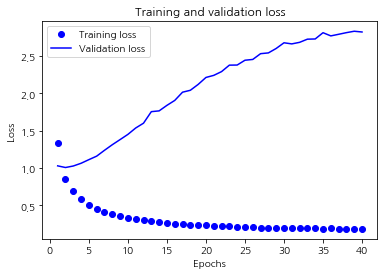

In [218]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

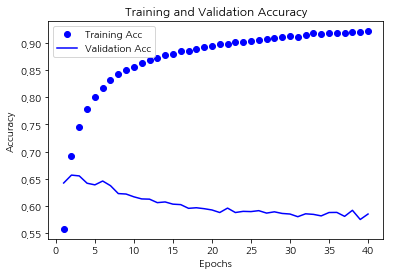

In [214]:
plt.clf()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [215]:
# 새로운 데이터 예측
predictions = model.predict(x_test)

In [203]:
# 46개의 항목에서 가장 큰 값이 예측 클래스가 됨
print(np.argmax(predictions[0]))

4


In [168]:
predictions[0]

array([9.3204025e-03, 1.6488084e-04, 5.6723520e-02, 2.5222498e-01,
       6.7725074e-01, 4.3154517e-03], dtype=float32)

In [204]:
pred_list = []
for i in range(len(predictions)):
    pred_list.append(np.argmax(predictions[i]))

In [205]:
pred_list = np.array(pred_list)

In [206]:
y_test

array([4, 2, 4, ..., 5, 0, 1])

In [251]:
cnt = 0
for i, j in zip(pred_list, y_test):
    if i == j:
        cnt += 1

print(cnt)

3371


In [252]:
len(y_test)

5849

In [253]:
pred_list

array([4, 2, 2, ..., 5, 0, 4])

In [254]:
target_names = list(set(y_train))

In [255]:
target_names

[0, 1, 2, 3, 4, 5]

In [256]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.DataFrame(confusion_matrix(y_test, pred_list),
                            index=target_names,
                            columns=target_names)

,0,1,2,3,4,5
0,663,68,41,105,32,90
1,74,590,69,71,47,85
2,46,62,552,69,185,55
3,91,81,69,533,53,173
4,40,72,143,98,558,88
5,115,81,59,146,70,475
